#### Import Dependencies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import itertools

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.utils.multiclass import unique_labels # for confusion matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#### Data Dictionary

**Data Dictionary**

- pol_eff_dt - auto insurance policy effective date
- gender - gender of driver: F, M
- agecat - driver's age category: 1 (youngest), 2, 3, 4, 5, 6
- credit_score - driver’s credit score(integer): 1-100, 1=poor, 100=excellent
- area - driver's area of residence: A, B, C, D, E, F
- traffic_index - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average
- veh_age - age of vehicle(categorical): 1 (youngest), 2, 3, 4
- veh_body - vehicle body, coded as:
    - BUS
    - CONVT = convertible  
    - COUPE   
    - HBACK = hatchback                  
    - HDTOP = hardtop
    - MCARA = motorized caravan
    - MIBUS = minibus
    - PANVN = panel van
    - RDSTR = roadster
    - SEDAN    
    - STNWG = station wagon
    - TRUCK           
    - UTE = utility
- veh_value - vehicle value, in \\$10,000s
- claim_office - office location of claim handling agent: A, B, C, D
- traffic2 - traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average.  Null values have imputed mean of full dataset
- veh_value2 - vehicle value, in \\$10,000s. Null values have been replaces with the mean of the full dataset
- veh_value3 - vehicle value, in \\$10,000s. Null values have been replaces with the median of the full dataset
- veh_age2 - age of vehicle(categorical): 1 (youngest), 2, 3, 4.  Null values have been replaces with the most frequent category, which is 2
- credit2 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the mean of the full dataset
- credit3 - driver’s credit score(integer): 1-100, 1=poor, 100=excellent. Null values have been replaces with the median of the full dataset
- dob - driver's date of birth
- age - Driver's age at policy effective date
- claim_ind - Indicates if the policy had a claim (=1) or not
- veh_body2 - vehicle body, with a collapsed type coding, as described below.  Original coding on left, new coding on right:
    - 'BUS' = 'MIBUS',
    - 'CONVT' = 'HDTOP'
    - 'COUPE' = 'COUPE'
    - 'HBACK' = 'HBACK'
    - 'HDTOP' = 'HDTOP'
    - 'MCARA' = 'MIBUS'
    - 'MIBUS' = 'MIBUS'
    - 'PANVN' = 'PANVN'
    - 'RDSTR' = 'HDTOP'
    - 'SEDAN' = 'SEDAN'
    - STNWG' = 'STNWG'
    - 'TRUCK' = 'TRUCK'
    - 'UTE' = 'UTE'

- numclaims - number of claims(integer): 0 if no claim
- claimcst0 - claim amount: 0 if no claim.  This is the total one year claim amount (ultimate loss) for the policy. 


#### DataFrame Dictionary

# Obtaining the Data

In [2]:
data = pd.read_csv('autoinsurance_claims.csv')
data.head()

,pol_number,pol_eff_dt,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,traffic2,veh_value2,veh_value3,veh_age2,credit2,credit3,dob,age,claim_ind,veh_body2,numclaims,claimcst0
0,80750205,7/1/2015,M,4,52.0,C,93.0,4.0,STNWG,2.96,NaN,93,2.96,2.96,4,52.000000,52,2/18/1963,53,0,STNWG,0,0.0
1,90994433,8/1/2015,M,3,83.0,C,108.0,4.0,SEDAN,1.89,NaN,108,1.89,1.89,4,83.000000,83,2/18/1978,38,0,SEDAN,0,0.0
2,59239520,7/1/2015,M,5,71.0,A,NaN,3.0,SEDAN,2.75,NaN,100,2.75,2.75,3,71.000000,71,4/14/1960,56,0,SEDAN,0,0.0
3,67030771,11/1/2015,M,3,NaN,B,77.0,3.0,UTE,2.92,NaN,77,2.92,2.92,3,74.730883,81,12/23/1974,41,0,UTE,0,0.0
4,91422215,8/1/2015,M,2,88.0,D,NaN,4.0,STNWG,3.63,NaN,100,3.63,3.63,4,88.000000,88,12/25/1984,31,0,STNWG,0,0.0


In [3]:
data.shape

(60948, 23)

# Preprocessing

In [4]:
# looking for null values
data.isnull().sum()

pol_number           0
pol_eff_dt           0
gender               0
agecat               0
credit_score      3014
area                 0
traffic_index    12250
veh_age          10476
veh_body             0
veh_value         7562
claim_office     56787
traffic2             0
veh_value2           0
veh_value3           0
veh_age2             0
credit2              0
credit3              0
dob                  0
age                  0
claim_ind            0
veh_body2            0
numclaims            0
claimcst0            0
dtype: int64

__Dropping Columns__

In [5]:
# claim office is mostly empty; lets drop the feature
# we don't need the policy number either
# veh_body and veh_body2 are redundant, keep veh_body2 as it is updated
# the dateTime columns create a complexity we could do without.  pol_eff_dt is proprietary info we don't need and dob is
  # redundant since we have age. 
data.drop(['claim_office', 'pol_number', 'veh_body', 'pol_eff_dt', 'dob'], axis = 1, inplace = True)




there are duplicate columns for credit_score, traffic_index, vehicle_value, containing null values, where either the mean, median or both were used to impute missing values.  Lets keep only columns with median imputation

In [6]:
# drop credit_score and credit2 columns
data.drop(['credit_score', 'credit2', 'traffic_index', 'veh_value', 'veh_value2'], axis = 1, inplace = True)

vehicle age also has a duplicate column, where the mode was used for null values.  This is an ordinal value so keeping the mode for imputation makes sense

In [7]:
# drop veh_age column
data.drop('veh_age', axis =1, inplace=True)

In [8]:
# confirm we have no other null values
data.isnull().sum()

gender        0
agecat        0
area          0
traffic2      0
veh_value3    0
veh_age2      0
credit3       0
age           0
claim_ind     0
veh_body2     0
numclaims     0
claimcst0     0
dtype: int64

**Fix Data Types**

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null object
agecat        60948 non-null int64
area          60948 non-null object
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null int64
veh_body2     60948 non-null object
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: float64(2), int64(7), object(3)
memory usage: 5.6+ MB




| Feature | Change Type to: |
|------------|---------------------|
| gender | change to category |
| agecat | change to category |
| area | change to category |
| veh_age2 | change to category |
| dob | change to DateTime |
| claim_ind | change to category |
| veh_body2 | change to category |


In [10]:
data = data.astype({'gender':'category', 'area':'category', 
             'claim_ind':'category', 'veh_body2':'category'}, inplace = True)

In [11]:
# double check the work
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 12 columns):
gender        60948 non-null category
agecat        60948 non-null int64
area          60948 non-null category
traffic2      60948 non-null int64
veh_value3    60948 non-null float64
veh_age2      60948 non-null int64
credit3       60948 non-null int64
age           60948 non-null int64
claim_ind     60948 non-null category
veh_body2     60948 non-null category
numclaims     60948 non-null int64
claimcst0     60948 non-null float64
dtypes: category(4), float64(2), int64(6)
memory usage: 4.0 MB


**Edit Column Names**

Lets change a few of the column names for ease of use as we move forward and work with the data

In [12]:
data.rename(columns={'traffic2':'traffic_index', 'veh_value3':'veh_value', 'credit3':'credit_score', 'numclaims':'num_claims', 
             'claimcst0':'claim_amount', 'veh_age2':'veh_ageIndex'}, inplace=True)

**Look for Multicolinearity**

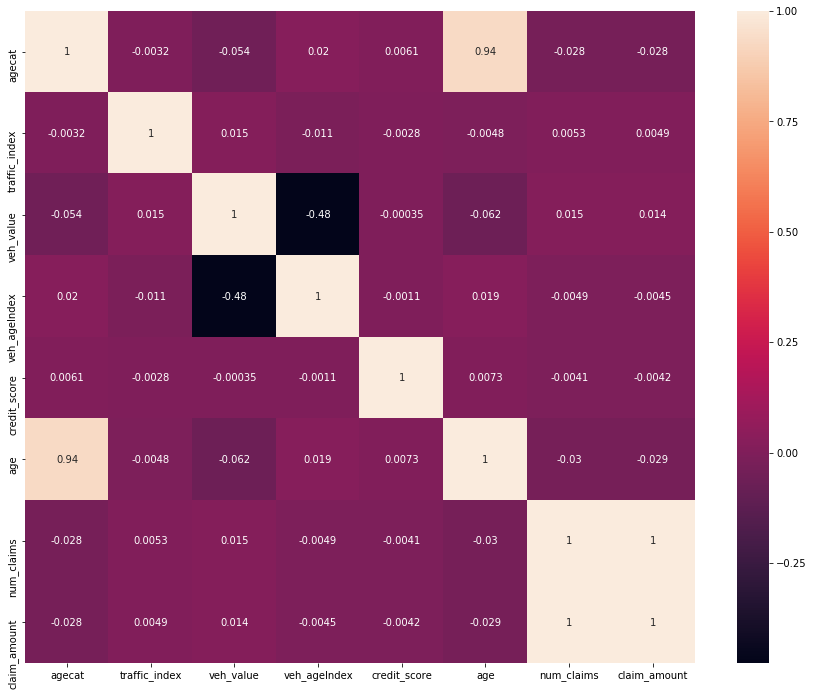

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(data.corr(), annot=True)

we see some highly correlated independent variables.  Lets get through the vanilla model and then decided what features to drop.

**Split data set between categorical and continuous**

I will treat ordinal features as numeric data.  Doing this requires the assumption that the numeric space between each category is equal or close to equal.   To ignore the ordering would essentially mean we could delete columns for the drivers age, the traffic index, vehicle age and credit score; that would be too much useful information to lose and an extreme downside.  The downside to treating this data as numeric is that if the spread between bins are not equal, then our results may only be approximate.  I would posit that the approximate results would be more accurate than any model that disregarded them. 

In [14]:
# create continuous sub-DataFrame

continuous = data.copy()
for i in continuous:
    if continuous[i].dtype.name == 'category':
        continuous.drop(i, axis=1, inplace = True)
continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 8 columns):
agecat           60948 non-null int64
traffic_index    60948 non-null int64
veh_value        60948 non-null float64
veh_ageIndex     60948 non-null int64
credit_score     60948 non-null int64
age              60948 non-null int64
num_claims       60948 non-null int64
claim_amount     60948 non-null float64
dtypes: float64(2), int64(6)
memory usage: 3.7 MB


In [15]:
continuous.head()

,agecat,traffic_index,veh_value,veh_ageIndex,credit_score,age,num_claims,claim_amount
0,4,93,2.96,4,52,53,0,0.0
1,3,108,1.89,4,83,38,0,0.0
2,5,100,2.75,3,71,56,0,0.0
3,3,77,2.92,3,81,41,0,0.0
4,2,100,3.63,4,88,31,0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE24D3AB38>,
      dtype=object)

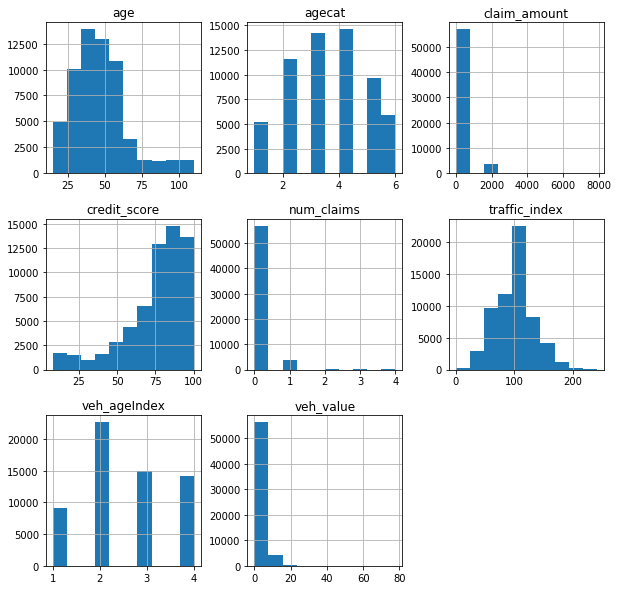

In [16]:
# inspect distributions for continuous data
continuous.hist(figsize=(10,10))

In [17]:
for col in continuous:
    print(col,':')
    print(continuous[col].value_counts(),'\n')

agecat :
4    14585
3    14177
2    11539
5     9634
6     5853
1     5160
Name: agecat, dtype: int64 

traffic_index :
100    12760
76       562
72       558
84       544
77       544
75       531
86       527
79       516
80       508
82       507
90       503
91       503
81       502
66       499
73       497
74       497
78       496
89       491
87       488
69       486
93       485
65       483
98       481
83       481
70       477
85       474
71       470
63       468
96       462
102      461
       ...  
5          5
4          5
205        5
0          4
208        4
217        4
9          4
204        4
13         4
206        4
212        3
8          3
203        3
224        3
2          3
220        2
216        2
1          2
215        2
6          2
3          2
241        1
230        1
235        1
11         1
232        1
218        1
221        1
222        1
223        1
Name: traffic_index, Length: 228, dtype: int64 

veh_value :
3.38     7942
3.06      43

veh_value, claim_amount and num_claims are so heavily skewed that it doesnt make sense to keep the columns

In [18]:
continuous.drop(['veh_value', 'claim_amount', 'num_claims'], axis=1, inplace=True)

In [19]:
# feature scaling -- Normalize the continuous data

scalar = StandardScaler()
cont_scaled = scalar.fit_transform(continuous)
print(type(cont_scaled))

<class 'numpy.ndarray'>


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


scikit turned the Pandas DataFrame into a Numpy array and also stripped the column headers.  
Lets coerce into Pandas and put the headers back on.  

In [20]:
cont_scaled_df = pd.DataFrame(cont_scaled, columns = continuous.columns)
cont_scaled_df.head()

,agecat,traffic_index,veh_ageIndex,credit_score,age
0,0.361650,-0.183470,1.431967,-1.123803,0.351709
1,-0.340432,0.289758,1.431967,0.388199,-0.464101
2,1.063732,0.037370,0.437227,-0.197092,0.514871
3,-0.340432,-0.688247,0.437227,0.290651,-0.300939
4,-1.042514,0.037370,1.431967,0.632070,-0.844813


In [21]:
# create categorical sub-DataFrame

categorical = data.copy()
for i in categorical:
    if categorical[i].dtype.name != 'category':
        categorical.drop(i, axis = 1, inplace=True)
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 238.9 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EE24EAAC18>,
      dtype=object)

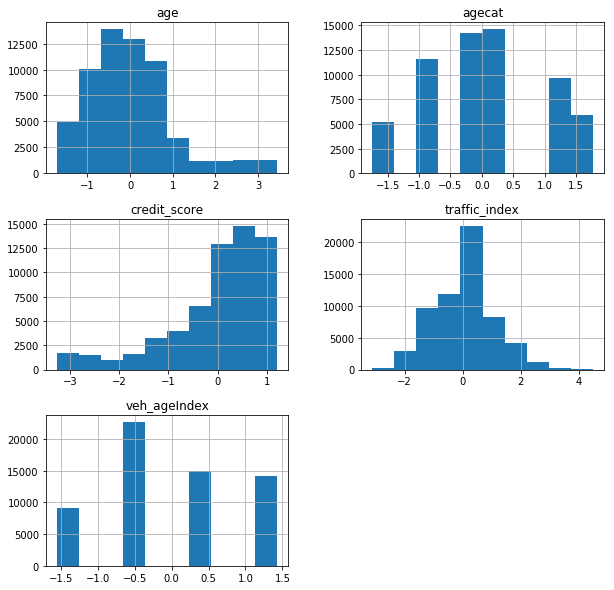

In [22]:
# inspect distributions for continuous data
cont_scaled_df.hist(figsize=(10,10))

In [23]:
for col in cont_scaled_df:
    print(col,':')
    print(cont_scaled_df[col].value_counts(),'\n')

agecat :
 0.361650    14585
-0.340432    14177
-1.042514    11539
 1.063732     9634
 1.765814     5853
-1.744595     5160
Name: agecat, dtype: int64 

traffic_index :
 0.037370    12760
-0.719796      562
-0.845990      558
-0.467407      544
-0.688247      544
-0.751344      531
-0.404310      527
-0.625150      516
-0.593601      508
-0.530504      507
-0.278116      503
-0.246567      503
-0.562053      502
-1.035281      499
-0.782893      497
-0.814441      497
-0.656698      496
-0.309664      491
-0.372761      488
-0.940636      486
-0.183470      485
-1.066830      483
-0.498956      481
-0.025727      481
-0.909087      477
-0.435859      474
-0.877538      470
-1.129927      468
-0.088824      462
 0.100467      461
             ...  
 3.349969        5
-2.991292        5
-2.959743        5
 3.381517        4
-3.117486        4
 3.318420        4
-2.833549        4
 3.444614        4
-2.707355        4
 3.728551        4
 3.570809        3
 3.286872        3
 3.949391      

**Get Dummies for categorical data**

In [24]:
categorical.head()

,gender,area,claim_ind,veh_body2
0,M,C,0,STNWG
1,M,C,0,SEDAN
2,M,A,0,SEDAN
3,M,B,0,UTE
4,M,D,0,STNWG


In [25]:
categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 4 columns):
gender       60948 non-null category
area         60948 non-null category
claim_ind    60948 non-null category
veh_body2    60948 non-null category
dtypes: category(4)
memory usage: 238.9 KB


In [26]:
categorical.veh_body2.value_counts()

SEDAN    19981
HBACK    16966
STNWG    14646
UTE       4108
TRUCK     1576
HDTOP     1506
MIBUS      794
COUPE      704
PANVN      667
Name: veh_body2, dtype: int64

In [27]:
# one-hot encode categorical data
dummies = pd.get_dummies(categorical.drop('claim_ind', axis=1))
dummies.head()

,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [28]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 17 columns):
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
dtypes: uint8(17)
memory usage: 1011.9 KB


**concat the continuous and categorical DataFrames**

In [29]:
#beginning processed dataframe
df = pd.concat([cont_scaled_df, dummies, categorical.claim_ind], axis = 1, sort=False)
df.head()

,agecat,traffic_index,veh_ageIndex,credit_score,age,gender_F,gender_M,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,0.361650,-0.183470,1.431967,-1.123803,0.351709,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.340432,0.289758,1.431967,0.388199,-0.464101,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.063732,0.037370,0.437227,-0.197092,0.514871,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.340432,-0.688247,0.437227,0.290651,-0.300939,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.042514,0.037370,1.431967,0.632070,-0.844813,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60948 entries, 0 to 60947
Data columns (total 23 columns):
agecat             60948 non-null float64
traffic_index      60948 non-null float64
veh_ageIndex       60948 non-null float64
credit_score       60948 non-null float64
age                60948 non-null float64
gender_F           60948 non-null uint8
gender_M           60948 non-null uint8
area_A             60948 non-null uint8
area_B             60948 non-null uint8
area_C             60948 non-null uint8
area_D             60948 non-null uint8
area_E             60948 non-null uint8
area_F             60948 non-null uint8
veh_body2_COUPE    60948 non-null uint8
veh_body2_HBACK    60948 non-null uint8
veh_body2_HDTOP    60948 non-null uint8
veh_body2_MIBUS    60948 non-null uint8
veh_body2_PANVN    60948 non-null uint8
veh_body2_SEDAN    60948 non-null uint8
veh_body2_STNWG    60948 non-null uint8
veh_body2_TRUCK    60948 non-null uint8
veh_body2_UTE      60948 non-null uint8
c

# Logistic Regression Models

Lets check for any class imbalance in our target variable

In [31]:
df.claim_ind.value_counts()

0    56787
1     4161
Name: claim_ind, dtype: int64

Roughly 7% of the target data are True while 93% are False so, it looks like we do have class imbalance and will run SMOTE to fix it.

## Logistic Regression Model #1

this model:
> - SMOTE completed before train-test split
> - with multicolinearity

In [32]:
# define X and y 
X = df[df.columns[:-1]]
y = df.claim_ind

# resample X and y with SMOTE 
X_resampled, y_resampled = SMOTE().fit_sample(X, y)

# preview synthtic sample claim_ind distribution
print(pd.Series(y_resampled).value_counts())

1    56787
0    56787
dtype: int64


In [33]:
# split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

In [34]:
# create a Logistic Regression Object
logreg_classifier = LogisticRegression()

# fit a logistic regression model with default parameters
logreg_model = logreg_classifier.fit(X_train, y_train)
print(logreg_model)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [35]:
# generating predictions

# using model to generate predictions off training data
y_hat_train = logreg_model.predict(X_train)
# using model to generate predictions off test data
y_hat_test = logreg_model.predict(X_test)

In [36]:
print(y_test.shape)
print(y_hat_test.shape)

(34073,)
(34073,)


In [37]:
np.unique(y_hat_test)

array([0, 1], dtype=int64)

In [38]:
accuracy_score(y_test, y_hat_test)

0.5380506559445896

In [39]:
print(classification_report(y_test,y_hat_test))

              precision    recall  f1-score   support

           0       0.56      0.43      0.48     17248
           1       0.53      0.65      0.58     16825

   micro avg       0.54      0.54      0.54     34073
   macro avg       0.54      0.54      0.53     34073
weighted avg       0.54      0.54      0.53     34073



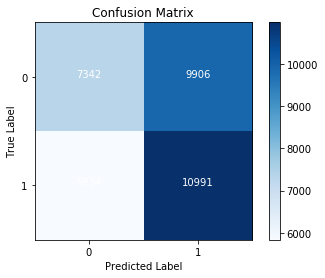

In [40]:
# Confusion Matrix

def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

show_cf(y_test, y_hat_test)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.5487354960895611


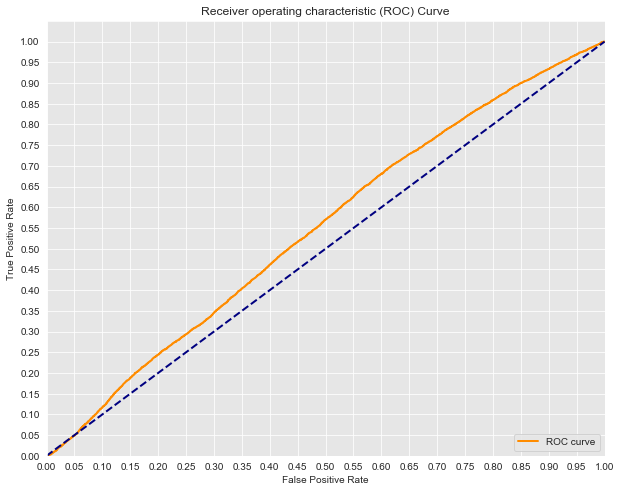

In [41]:
# calculate and plot ROC curve

y_score = logreg_model.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The logistic classification model is performing perfectly for both the training and test sets.  Lets fix multicolinearity and see if we can get some realistic results

## Logistic Regression Model #2

LR model #1 did not remove multicolinearity.  
Correlated features included: age with age_cat, and claim_amount with num_claims.  
This LR model #2 will be completed after removing age and claim_amount.  
SMOTE is also completed before train-test split

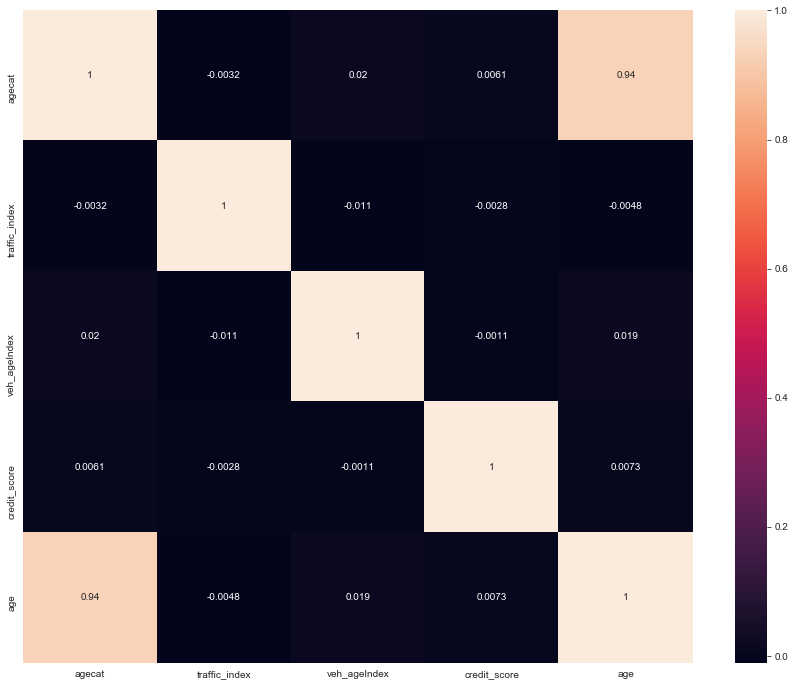

In [42]:
# view heatmap again
plt.figure(figsize=(15, 12))
sns.heatmap(cont_scaled_df.corr(), annot=True)

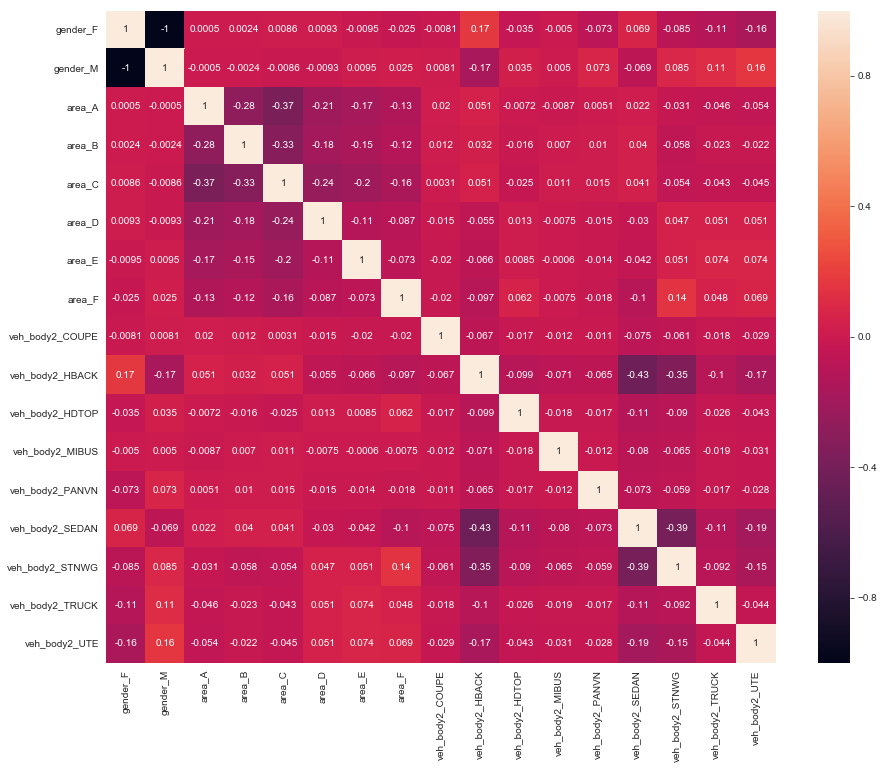

In [43]:
# view heatmap again
plt.figure(figsize=(15, 12))
sns.heatmap(dummies.corr(), annot=True)

We clearly need to drop a couple more columns.  
**Continuous Features**
Between age and age cat, lets keep age cat since the insurance company has already binned groups.  
And between num_claims and claim_amount; we kept num_claims on previous iterations with not so stellar results.  Lets drop num_claims this time. 

**Categorical Features**
Genders are perfectly negatively correlated.  Lets drop gender_M this go-around.

In [44]:
# dropping 'age' and 'claim_amount'
cont_df_2 = continuous.copy()
cont_df_2.drop(['age'], axis = 1, inplace = True)
dummies_2 = dummies.copy()
dummies_2.drop(['gender_M'], axis=1, inplace=True)

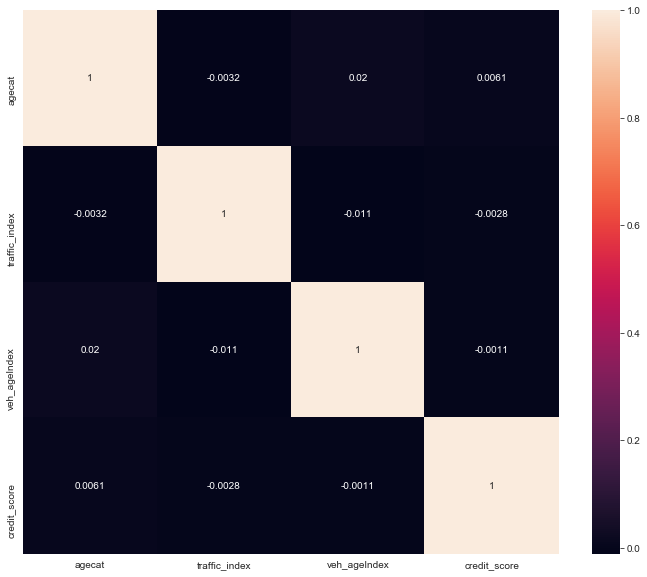

In [45]:
# correlation heatmap after removed of correlated features in continuous data
plt.figure(figsize=(12, 10))
sns.heatmap(cont_df_2.corr(), annot=True)

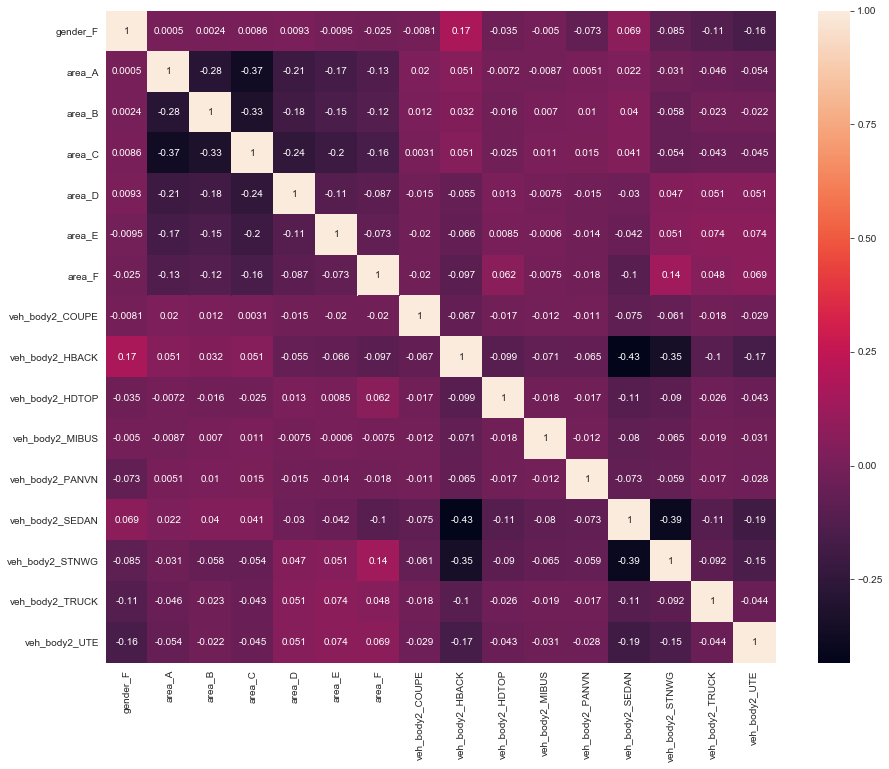

In [46]:
# correlation heatmap after removed of correlated features in categorical data
plt.figure(figsize=(15, 12))
sns.heatmap(dummies_2.corr(), annot=True)

In [47]:
df_2 = pd.concat([cont_df_2, dummies_2, categorical.claim_ind], axis = 1, sort=False)
df_2.head()

,agecat,traffic_index,veh_ageIndex,credit_score,gender_F,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,4,93,4,52,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,3,108,4,83,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5,100,3,71,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,77,3,81,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,100,4,88,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [48]:
# define X and y 
X2 = df_2[df_2.columns[:-1]]
y2 = df_2.claim_ind

# resample X and y with SMOTE 
X_resampled_2, y_resampled_2 = SMOTE().fit_sample(X2, y2)

# split the resampled data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_resampled_2, y_resampled_2, test_size = 0.3, random_state = 42)

In [49]:
# fit a logistic regression model with default parameters
logreg_model_2 = logreg_classifier.fit(X_train_2, y_train_2)
print(logreg_model_2)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [50]:
# generating predictions
y_hat_train_2 = logreg_model.predict(X_train_2)
y_hat_test_2 = logreg_model_2.predict(X_test_2)

In [51]:
accuracy_score(y_test_2, y_hat_test_2)

0.9066709711501776

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2,y_hat_test_2))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92     17248
           1       1.00      0.81      0.90     16825

   micro avg       0.91      0.91      0.91     34073
   macro avg       0.92      0.91      0.91     34073
weighted avg       0.92      0.91      0.91     34073



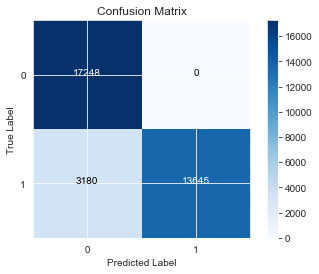

In [53]:
show_cf(y_test_2, y_hat_test_2)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.9354974472566278


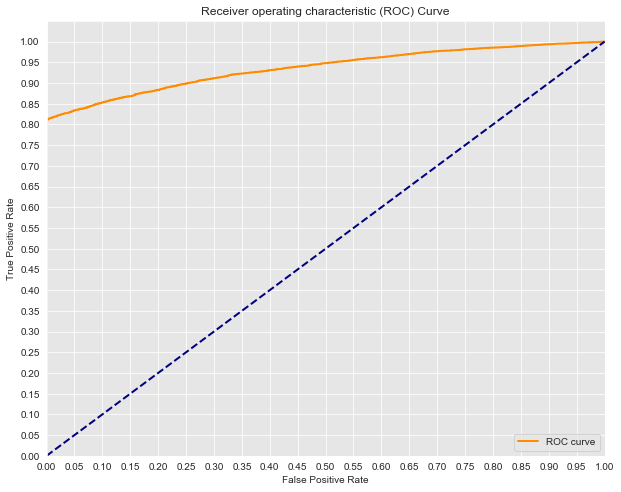

In [54]:
y_score_2 = logreg_model_2.fit(X_train_2, y_train_2).decision_function(X_test_2)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_2, y_score_2)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_2, tpr_2)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Removing multicolinearity had no effecto on model results which are still perfect and unrealistic.  Lets move on to Random Forests for (hopefully) more insight which might tell us that Logistic Regression is simply not sensitive enough for thid data.

## Logistic Regression Model #3 

Running a Random Forest model showed 98% importance being attributed to num_claims.  This was highly correlation with claim_amount, which was removed before LR Model #2.  Lets drop num_claims and run another LR model to see if we can get some realistic results.   
Also, **implementing SMOTE after train-test split for this iteration**

In [55]:
df_3 = df_2.copy()
df_3.head()

,agecat,traffic_index,veh_ageIndex,credit_score,gender_F,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE,claim_ind
0,4,93,4,52,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,3,108,4,83,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5,100,3,71,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,77,3,81,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,100,4,88,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [56]:
import copy

X_3 = copy.deepcopy(df_3[df_3.columns[0:-1]])
y_3 = copy.deepcopy(df_3.claim_ind)

# split data set between test and train
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.3, random_state = 42)

# complete SMOTE on train sample only
X_train_3_SMOTE, y_train_3_SMOTE = SMOTE().fit_sample(X_train_3, y_train_3)
           

In [57]:
logreg_classifier = LogisticRegression()
logReg_model_3 = logreg_classifier.fit(X_train_3_SMOTE, y_train_3_SMOTE)
print(logReg_model_3)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [58]:
# generating predictions
y_hat_train_3 = logReg_model_3.predict(X_train_3_SMOTE)
y_hat_test_3 = logReg_model_3.predict(X_test_3)

In [59]:
accuracy_score(y_test_3, y_hat_test_3)

0.93021602406344

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test_3,y_hat_test_3))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17009
           1       0.00      0.00      0.00      1276

   micro avg       0.93      0.93      0.93     18285
   macro avg       0.47      0.50      0.48     18285
weighted avg       0.87      0.93      0.90     18285



C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


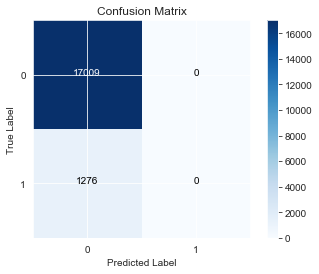

In [61]:
show_cf(y_test_3, y_hat_test_3)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.5445631217550141


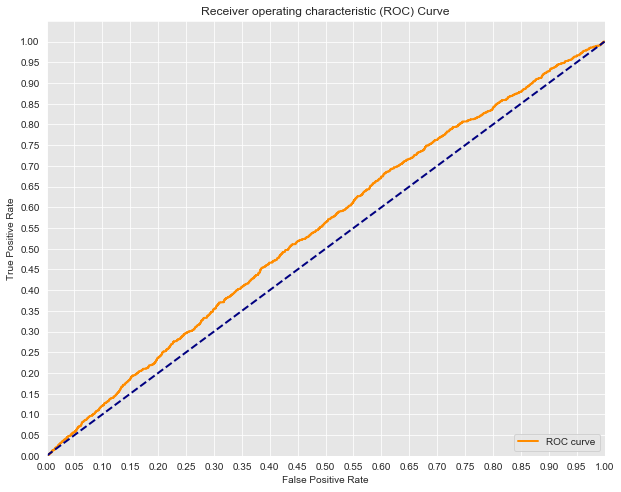

In [62]:
y_score_3 = logReg_model_3.fit(X_train_3, y_train_3).decision_function(X_test_3)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test_3, y_score_3)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_3, tpr_3)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Random Forest Models

## RF Model #1

- started with same DF as LR model #2
- SMOTE after train-test split

In [63]:
RF_data = df_2.copy()

RF_X = RF_data.drop(['claim_ind'], axis=1)
RF_y = RF_data.claim_ind

In [64]:
RF_data_train, RF_data_test, RF_target_train, RF_target_test = train_test_split(RF_X, RF_y, test_size = 0.3, random_state=42) 


In [65]:
RF_target_test.value_counts()

0    17009
1     1276
Name: claim_ind, dtype: int64

In [66]:
# complete SMOTE on train sample only
RF_X_train_SMOTE, RF_y_train_SMOTE = SMOTE().fit_sample(RF_data_train, RF_target_train)

In [67]:
pd.Series(RF_y_train_SMOTE).value_counts()

1    39778
0    39778
dtype: int64

In [68]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(RF_X_train_SMOTE, RF_y_train_SMOTE)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
pred_1 = forest.predict(RF_data_test)

print(accuracy_score(RF_target_test, pred_1))
print(confusion_matrix(RF_target_test, pred_1))
print(classification_report(RF_target_test, pred_1))

0.8762920426579163
[[15925  1084]
 [ 1178    98]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     17009
           1       0.08      0.08      0.08      1276

   micro avg       0.88      0.88      0.88     18285
   macro avg       0.51      0.51      0.51     18285
weighted avg       0.87      0.88      0.87     18285



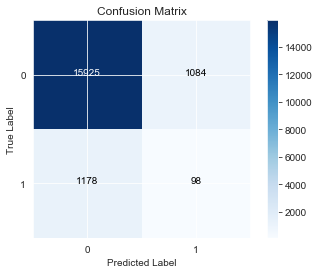

In [70]:
show_cf(RF_target_test, pred_1)

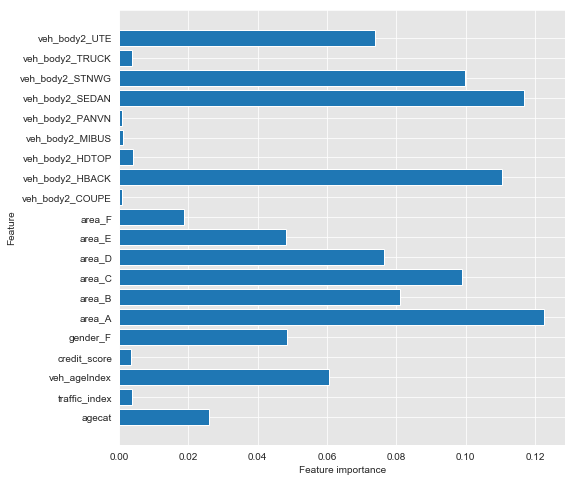

In [71]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances(forest, RF_data_train)

In [72]:
RF_data.columns[1]

'traffic_index'

In [73]:

for name, importance in zip(RF_data.columns, forest.feature_importances_):
    print(name, "=", f"{round(importance*100)}'%'")

agecat = 3.0'%'
traffic_index = 0.0'%'
veh_ageIndex = 6.0'%'
credit_score = 0.0'%'
gender_F = 5.0'%'
area_A = 12.0'%'
area_B = 8.0'%'
area_C = 10.0'%'
area_D = 8.0'%'
area_E = 5.0'%'
area_F = 2.0'%'
veh_body2_COUPE = 0.0'%'
veh_body2_HBACK = 11.0'%'
veh_body2_HDTOP = 0.0'%'
veh_body2_MIBUS = 0.0'%'
veh_body2_PANVN = 0.0'%'
veh_body2_SEDAN = 12.0'%'
veh_body2_STNWG = 10.0'%'
veh_body2_TRUCK = 0.0'%'
veh_body2_UTE = 7.0'%'


lets drop any feature scoring less than 5% and run the model again.

## RF Model #3

- remove features with importance of < 0.05

In [74]:
for name, importance in zip(RF_data.columns, forest.feature_importances_):
    my_dict = {name: round(importance*100)}
    print(my_dict)



{'agecat': 3.0}
{'traffic_index': 0.0}
{'veh_ageIndex': 6.0}
{'credit_score': 0.0}
{'gender_F': 5.0}
{'area_A': 12.0}
{'area_B': 8.0}
{'area_C': 10.0}
{'area_D': 8.0}
{'area_E': 5.0}
{'area_F': 2.0}
{'veh_body2_COUPE': 0.0}
{'veh_body2_HBACK': 11.0}
{'veh_body2_HDTOP': 0.0}
{'veh_body2_MIBUS': 0.0}
{'veh_body2_PANVN': 0.0}
{'veh_body2_SEDAN': 12.0}
{'veh_body2_STNWG': 10.0}
{'veh_body2_TRUCK': 0.0}
{'veh_body2_UTE': 7.0}


In [75]:
# keep 

In [76]:
# create new dataFrame object with credit_score, veh_ageindex, veh_value, traffic_index, agecat
import copy # using the python copy.deepcopy will let me use the DataFrame as an attribute, which will let me call the features
              # I want to keep (5 ttl) instead of using pandas .copy() and dropping 17 features; just a little time savings.
    
RF_data_3 = copy.deepcopy(RF_data[[ 'veh_ageIndex', 'area_A', 'area_B','area_C',
                                   'area_D','veh_body2_HBACK', 'veh_body2_SEDAN','veh_body2_STNWG'
                                   ]])

In [77]:
RF_data_3.head()

,veh_ageIndex,area_A,area_B,area_C,area_D,veh_body2_HBACK,veh_body2_SEDAN,veh_body2_STNWG
0,4,0,0,1,0,0,0,1
1,4,0,0,1,0,0,1,0
2,3,1,0,0,0,0,1,0
3,3,0,1,0,0,0,0,0
4,4,0,0,0,1,0,0,1


In [78]:
# define predictor set and target series
RF_X_3 = RF_data_3.copy()
RF_y_3 = RF_y.copy()

# split data into train and test sets
RF_data_train_3, RF_data_test_3, RF_target_train_3, RF_target_test_3 = train_test_split(RF_X_3, RF_y_3, test_size = 0.3, 
                                                                                        random_state=42) 
# run SMOTE
RF_X_train_SMOTE_3, RF_y_train_SMOTE_3 = SMOTE().fit_sample(RF_data_train_3, RF_target_train_3)

# create a random forest classifier object
forest_3 = RandomForestClassifier(n_estimators=100, max_depth= 5)

# fit the model
forest_3.fit(RF_X_train_SMOTE_3, RF_y_train_SMOTE_3)

# generate predictions
pred_3 = forest_3.predict(RF_data_test_3)



In [79]:
pd.DataFrame(RF_X_train_SMOTE_3).head()

,0,1,2,3,4,5,6,7
0,2,0,0,1,0,0,0,1
1,4,1,0,0,0,1,0,0
2,3,0,0,0,0,0,1,0
3,1,0,0,0,1,0,1,0
4,4,0,0,0,1,0,1,0


In [80]:
RF_data_train_3.head()

,veh_ageIndex,area_A,area_B,area_C,area_D,veh_body2_HBACK,veh_body2_SEDAN,veh_body2_STNWG
36401,2,0,0,1,0,0,0,1
53924,4,1,0,0,0,1,0,0
59620,3,0,0,0,0,0,1,0
27508,1,0,0,0,1,0,1,0
38199,4,0,0,0,1,0,1,0


In [81]:
print(f" Accuracy RF model #3: {accuracy_score(RF_target_test_3, pred_3 )}")
pred_3 = forest_3.predict(RF_data_test_3)
print(confusion_matrix(RF_target_test_3, pred_3))
print(classification_report(RF_target_test_3, pred_3))

 Accuracy RF model #3: 0.5146294777139732
[[8787 8222]
 [ 653  623]]
              precision    recall  f1-score   support

           0       0.93      0.52      0.66     17009
           1       0.07      0.49      0.12      1276

   micro avg       0.51      0.51      0.51     18285
   macro avg       0.50      0.50      0.39     18285
weighted avg       0.87      0.51      0.63     18285



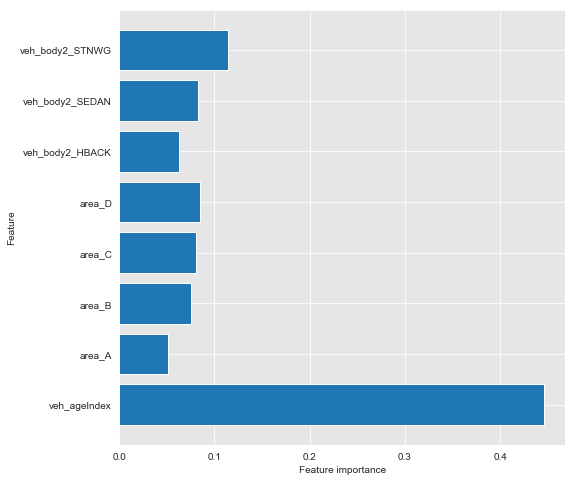

In [82]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(forest_3, RF_data_train_3)

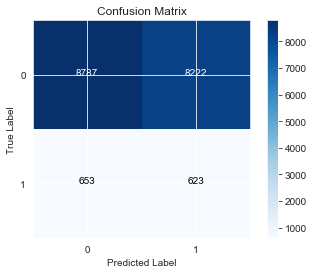

In [83]:
show_cf(RF_target_test_3, pred_3)

# XGBoost

## XGBoost Model #1 
 - before removing variables based on feature importance

In [84]:
import xgboost as xgb

In [85]:


# define X and y
boost_X = RF_X.copy()
boost_y = RF_y.copy()

# train-test split
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(boost_X, boost_y,  test_size = 0.3, 
                                                                                        random_state=42)

In [86]:
boost_X.head()

,agecat,traffic_index,veh_ageIndex,credit_score,gender_F,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
0,4,93,4,52,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,3,108,4,83,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,5,100,3,71,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,77,3,81,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,100,4,88,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [87]:
boost_y.head()

0    0
1    0
2    0
3    0
4    0
Name: claim_ind, dtype: category
Categories (2, int64): [0, 1]

In [88]:
# upsample with SMOTE
X_train_boost_SMOTE, y_train_boost_SMOTE = SMOTE().fit_sample(X_train_boost, y_train_boost)

In [89]:
X_train_boost_SMOTE_df =  pd.DataFrame(X_train_boost_SMOTE, columns = X_train_boost.columns)
X_train_boost_SMOTE_df.head()

,agecat,traffic_index,veh_ageIndex,credit_score,gender_F,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
0,1,136,2,87,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2,92,4,89,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,4,74,3,83,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,3,110,1,70,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,3,100,4,99,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [90]:
X_test_boost.head()

,agecat,traffic_index,veh_ageIndex,credit_score,gender_F,area_A,area_B,area_C,area_D,area_E,area_F,veh_body2_COUPE,veh_body2_HBACK,veh_body2_HDTOP,veh_body2_MIBUS,veh_body2_PANVN,veh_body2_SEDAN,veh_body2_STNWG,veh_body2_TRUCK,veh_body2_UTE
39967,1,84,4,91,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
53010,5,100,1,93,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
60863,4,169,2,80,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
36168,3,53,2,78,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
60028,4,83,2,79,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [91]:
X_test_boost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 39967 to 33285
Data columns (total 20 columns):
agecat             18285 non-null int64
traffic_index      18285 non-null int64
veh_ageIndex       18285 non-null int64
credit_score       18285 non-null int64
gender_F           18285 non-null uint8
area_A             18285 non-null uint8
area_B             18285 non-null uint8
area_C             18285 non-null uint8
area_D             18285 non-null uint8
area_E             18285 non-null uint8
area_F             18285 non-null uint8
veh_body2_COUPE    18285 non-null uint8
veh_body2_HBACK    18285 non-null uint8
veh_body2_HDTOP    18285 non-null uint8
veh_body2_MIBUS    18285 non-null uint8
veh_body2_PANVN    18285 non-null uint8
veh_body2_SEDAN    18285 non-null uint8
veh_body2_STNWG    18285 non-null uint8
veh_body2_TRUCK    18285 non-null uint8
veh_body2_UTE      18285 non-null uint8
dtypes: int64(4), uint8(16)
memory usage: 1000.0 KB


In [92]:
# create an XGBoost classifier object
clf = xgb.XGBClassifier()

# use XGBoost to fit our x and y training data
clf.fit(X_train_boost_SMOTE_df, y_train_boost_SMOTE)

# generate predictions using training features
boost_training_preds = clf.predict(X_train_boost_SMOTE_df)

# generate predictions using test features
boost_test_preds = clf.predict(X_test_boost)



In [93]:
training_accuracy = accuracy_score(y_train_boost_SMOTE, boost_training_preds)
test_accuracy = accuracy_score(y_test_boost, boost_test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 91.02%
Test accuracy: 92.96%


In [94]:
print(confusion_matrix(y_test_boost, boost_test_preds))
print(classification_report(y_test_boost, boost_test_preds))

[[16994    15]
 [ 1272     4]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17009
           1       0.21      0.00      0.01      1276

   micro avg       0.93      0.93      0.93     18285
   macro avg       0.57      0.50      0.48     18285
weighted avg       0.88      0.93      0.90     18285



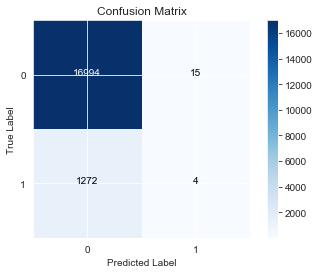

In [95]:
show_cf(y_test_boost, boost_test_preds)

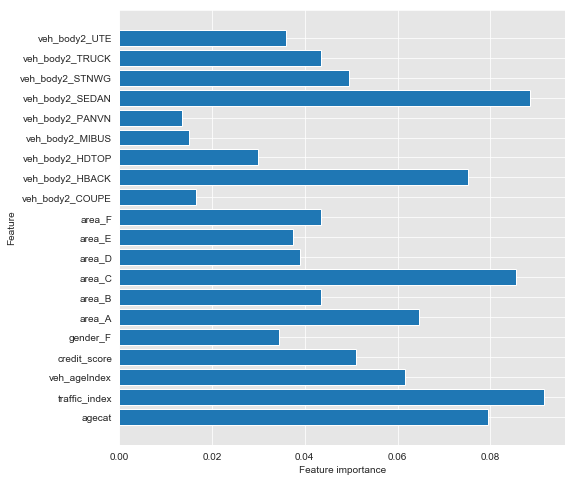

In [96]:
def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(clf, X_train_boost) # training data param here is just to get column headers for graph

the XGBoost is performing the best.  Lets further optimize with Grid Search

In [ ]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [7],
    'min_child_weight': [9],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250, 500],
    
}

In [ ]:
import time
start = time.time()

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_boost_SMOTE_df, y_train_boost_SMOTE)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_boost_SMOTE_df)
test_preds = grid_clf.predict(X_test_boost)
training_accuracy = accuracy_score(y_train_boost_SMOTE, training_preds)
test_accuracy = accuracy_score(y_test_boost, test_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

end = time.time()
print(end - start)

## XGBoost Model #2 
 - after removing variables based on feature importance

In [98]:
# define X and y
XG_data_2 = copy.deepcopy(RF_X[['veh_body2_SEDAN', 'veh_body2_HBACK', 'area_E', 'area_C', 'area_B', 'area_A',
                               'credit_score', 'veh_ageIndex', 'traffic_index', 'agecat']])
XG_y_2 = RF_y.copy()

# train-test split
X_train_boost_2, X_test_boost_2, y_train_boost_2, y_test_boost_2 = train_test_split(XG_data_2, XG_y_2,  test_size = 0.3, 
                                                                                        random_state=42)

# upsample with SMOTE
X_train_boost_SMOTE_2, y_train_boost_SMOTE_2 = SMOTE().fit_sample(X_train_boost_2, y_train_boost_2)

X_train_boost_SMOTE_2_df =  pd.DataFrame(X_train_boost_SMOTE_2, columns = X_train_boost_2.columns)

# create an XGBoost classifier object
boost_clf_2 = xgb.XGBClassifier()

# use XGBoost to fit our x and y training data
boost_clf_2.fit(X_train_boost_SMOTE_2_df, y_train_boost_SMOTE_2)

# generate predictions using training features
boost_training_preds_2 = boost_clf_2.predict(X_train_boost_SMOTE_2_df)

# generate predictions using test features
boost_test_preds_2 = boost_clf_2.predict(X_test_boost_2)

 Training Accuracy: 77.44733269646538
 Validation Accuracy: 73.10910582444626
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17009
           1       0.21      0.00      0.01      1276

   micro avg       0.93      0.93      0.93     18285
   macro avg       0.57      0.50      0.48     18285
weighted avg       0.88      0.93      0.90     18285



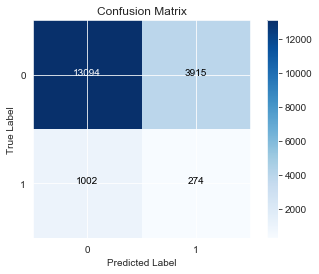

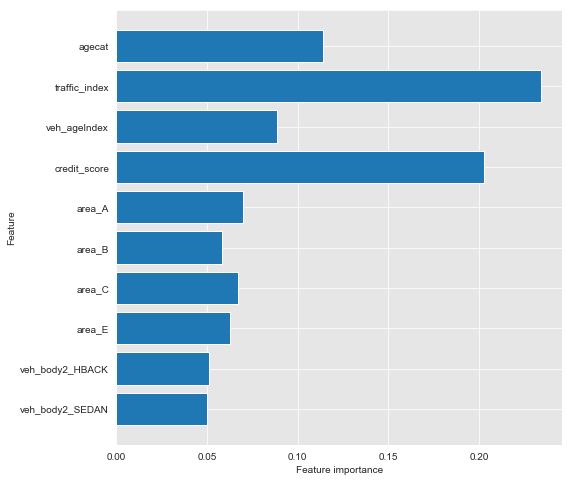

In [99]:
training_accuracy_2 = accuracy_score(y_train_boost_SMOTE_2, boost_training_preds_2)
test_accuracy_2 = accuracy_score(y_test_boost_2, boost_test_preds_2)

print(f" Training Accuracy: {training_accuracy_2*100}")
print(f" Validation Accuracy: {test_accuracy_2*100}")


show_cf(y_test_boost_2, boost_test_preds_2)


print(classification_report(y_test_boost, boost_test_preds))

def plot_feature_importances(model,training_feature_data):
    n_features = training_feature_data.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), training_feature_data.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(boost_clf_2, X_train_boost_2) # training data param here is just to get column headers for graph